In [10]:
import numpy as np
from numpy import matlib as ml
import pandas as pd
import os
import warnings
import librosa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from random import shuffle
import scipy.stats as st

from pynwb import NWBHDF5IO
from pynwb.epoch import TimeIntervals

from sklearn.decomposition import PCA

import pdb

In [2]:
# ----- SET UP FILE HANDLING -----

# !! Josh -- you will need to edit this block with your local path to the NWB files
# You can/should just download the NWB folder from the Scn2a project Box, then you can just point to that directory here
# and everything should just work (haha famous last words)
# If we end up collaborating on files enough to make it stupid to switch back and forth between your computer(s) and mine,
# we can set up environmental variables that will take care of it, but for now this dumb kludge should be okay

computer = 'Dorian'
# computer = 'Ernest'
# computer = 'Josh'

match computer:
    case 'Dorian':
        nwbpath = 'M:\\scn2a-paper-GWJSNH\\NWB-files'
        
    case 'Ernest':
        nwbpath = 'C:\\Users\\nhogl\\Documents\\GitHub\\scn2a-paper-GWJSNH-code\\NWB'
        
    case 'Josh':
        nwbpath = '\your\path\here' # EDIT ME

allnwb = []
allnwb += [os.path.join(nwbpath,each) for each in os.listdir(nwbpath) if each.endswith('.nwb')]

printy = True # EDIT ME if you don't want the loop over each file to print the file name

In [3]:
# ----- COLLATE TIME SPENT IN EACH STATE BEHAVIOR AND COUNTS OF EACH POINT BEHAVIOR FOR EACH ASSAY -----

# This cell looks in each NWB file and creates the summary metrics.  The idea is to do this once at the beginning then
# reconfigure the resulting dataframe for all subsequent analyses.  I did not functionalize it because it should just
# happen once at the beginning, but it might bear refactoring if we want more flexibility on the metrics

for i,fname in enumerate(allnwb): # loop over files
    # open file
    io = NWBHDF5IO(os.path.join(nwbpath,fname), mode="r") # <-- open in write to append snippets?
    nwbfile = io.read()
    
    # for sanity check, print out the name of the file being handled
    pathsplit = fname.split('\\')
    recstem = pathsplit[-1].strip('.nwb')
    if printy: # you can turn off filename printing by setting this to false
        print(recstem)
    
    # filter out files that don't have complete timelines
    if nwbfile.lab_meta_data['vole_metadata'].timeline_complete: # can I just get rid of this?
        data = nwbfile.intervals['annotated_behavior'].to_dataframe() # convert annotation table to dataframe
        df = data.copy()
        df=df[df.behavior!='Start assay']
        # get counts of all events and add a column to label as such
        counts = df.groupby('behavior')['start_time'].count().reset_index(name='number')
        nrcountsentries = counts.shape[0]
        counts['metric_label'] = ['count']*nrcountsentries
        # do median duration for state events and add a column to label as such
        medians = df[df.atype=='STATE'].groupby(['behavior'])['duration'].apply(np.median).reset_index(name='number')
        nrmediansentries = medians.shape[0]
        medians['metric_label'] = ['median']*nrmediansentries
        combined = pd.concat([counts,medians]) # combine table
        # PPT label conversion
        if nwbfile.lab_meta_data['vole_metadata'].assay_type=='PPT':
            if nwbfile.lab_meta_data['vole_metadata'].assay_type__partner_chamber=='Left':
                combined.behavior.replace({'Left':'Partner'}, regex=True,inplace=True)
                combined.behavior.replace({'Right':'Stranger'}, regex=True,inplace=True)
            elif nwbfile.lab_meta_data['vole_metadata'].assay_type__partner_chamber=='Right':
                combined.behavior.replace({'Right':'Partner'}, regex=True,inplace=True)
                combined.behavior.replace({'Left':'Stranger'}, regex=True,inplace=True)
            else:
                print('Invalid value for partner chamber.')
        nrbehav = combined.shape[0]
        # add metadata labels
        combined['ET'] = [nwbfile.subject.subject_id]*nrbehav
        combined['sex'] = [nwbfile.subject.sex]*nrbehav
        combined['GT'] = [nwbfile.subject.genotype]*nrbehav
        combined['assay'] = [nwbfile.lab_meta_data['vole_metadata'].assay_type]*nrbehav
        
        if i==0:
            rundf = combined
        else:
            rundf = pd.concat([rundf,combined])
        
    else:
        print('Incomplete timeline; skipping.')
        
# ----- ADJUST LABELS IN DATAFRAME AND CONVERT TO WIDE FORMAT FOR PCA -----

# add a column to cross reference behaviors to assays and metric
rundf['a-b-m'] = rundf['assay'].add('-').add(rundf['behavior']).add('-').add(rundf['metric_label'])

# rearrange table so that each individual has a row of data
wide = rundf.pivot(index=['ET','sex','GT'], columns='a-b-m', values='number')

# THIS STEP WILL BE A PROBLEM WITH ASSAYS THAT DON'T EXIST
# replace any missing values with zeros (as they did not occur)
filled = wide.fillna(0)

# pull metadata out of indices
filled = filled.reset_index(level=['sex', 'GT'])

# generate master list of observations; inventory of which behaviors appear in which assays
allcols = filled.columns

Nov22_Pair15_aggressio
Nov22_Pair15_introductio
Nov22_Pair15_PPT
Nov22_Pair15_reunio
Nov22_Pair15_timedMating
Nov22_Pair16_aggressio
Nov22_Pair16_introductio
Nov22_Pair16_PPT
Nov22_Pair16_reunio
Nov22_Pair16_timedMating
Nov22_Pair17_aggressio
Nov22_Pair17_introductio
Nov22_Pair17_PPT
Nov22_Pair17_reunio
Nov22_Pair17_timedMating
Nov22_Pair18_aggressio
Nov22_Pair18_introductio
Nov22_Pair18_PPT
Nov22_Pair18_reunio
Nov22_Pair18_timedMating
Nov22_Pair19_aggressio
Nov22_Pair19_introductio
Nov22_Pair19_PPT
Nov22_Pair19_reunio
Nov22_Pair19_timedMating
Nov22_Pair1_aggressio
Nov22_Pair1_introductio
Nov22_Pair1_PPT
Nov22_Pair1_reunio
Nov22_Pair1_timedMating
Nov22_Pair21_aggressio
Nov22_Pair21_introductio
Nov22_Pair21_PPT
Nov22_Pair21_reunio
Nov22_Pair21_timedMating
Nov22_Pair22_aggressio
Nov22_Pair22_introductio
Nov22_Pair22_PPT
Nov22_Pair22_reunio
Nov22_Pair22_timedMating
Nov22_Pair23_aggressio
Nov22_Pair23_introductio
Nov22_Pair23_PPT
Nov22_Pair23_reunio
Nov22_Pair23_timedMating
Nov22_Pair24_ag

In [4]:
# ----- TAKE A LOOK AT THE RESULTING TABLE FOR SANITY CHECK -----
filled.head()

a-b-m,sex,GT,PPT-Attack Partner-count,PPT-Attack Stranger-count,PPT-Center-count,PPT-Center-median,PPT-Huddle Partner-count,PPT-Huddle Partner-median,PPT-Huddle Stranger-count,PPT-Huddle Stranger-median,...,timedMating-Investigate-median,timedMating-Mount-count,timedMating-Mount-median,timedMating-No interaction-count,timedMating-No interaction-median,timedMating-Sniff-count,timedMating-Sniff-median,timedMating-Strike-count,timedMating-Tussle-count,timedMating-Tussle-median
ET,,,,,,,,,,,,,,,,,,,,,
B6611,M,Het,0.0,0.0,260.0,0.9990,121.0,3.7490,11.0,1.5000,...,0.8740,52.0,0.7485,117.0,3.2460,84.0,1.3730,0.0,0.0,0.0
B6613,M,WT,0.0,1.0,236.0,2.2455,258.0,5.4970,93.0,2.9940,...,0.9990,52.0,0.7495,71.0,5.2510,94.0,1.4990,0.0,0.0,0.0
B6614,F,Het,1.0,0.0,330.0,0.9975,157.0,2.5030,103.0,1.7510,...,0.9965,0.0,0.0000,172.0,3.5005,33.0,0.9980,1.0,0.0,0.0
B6615,F,WT,0.0,0.0,82.0,2.6260,52.0,6.1260,2.0,5.6255,...,0.9960,0.0,0.0000,85.0,7.9990,20.0,1.2520,0.0,0.0,0.0
B6616,M,WT,0.0,1.0,380.0,1.4990,70.0,1.7465,74.0,2.7490,...,1.9160,14.0,0.8345,82.0,2.5030,46.0,1.7505,0.0,0.0,0.0


In [5]:
# ----- SET UP COLORS -----

# I have found that just hardcoding this is most effective in practice, will need to be subbed if we change the colors

acols = [[0.627451,   0.57254905, 0.37254903], # all colors
        [0.9607843,  0.7882353,  0.15294118],
        [0.34901962, 0.35686275, 0.49019608],
        [0.24705882, 0.30588236, 0.9607843 ]]

fcols = acols[0:2] # female colors, WT first
mcols = acols[2:] # male colors, WT first

fpal = sns.color_palette(fcols) # create seaborn palettes for plotting
mpal = sns.color_palette(mcols)
apal = sns.color_palette(acols)

In [19]:
# ----- DEFINE DATA HANDLING FUNCTIONS ----

def check_column_labels(toUse,allCols):
    
    use = [] # keep track of which synthesized labels are represented
    
    for i,label in enumerate(toUse): # iterate over labels
        # check whether the label exists in the column list
        if label in allCols:
            use.append(label)
            
    return use

def generate_prospective_columns(useAssays,useBehaviors,useMetrics):
    
    # make all the label combinations out of the requested parts
    colsToUse = [assay+'-'+behav+'-'+metric for metric in useMetrics for behav in useBehaviors for assay in useAssays]
    
    return colsToUse

def validate_columns(assays,behaviors,metrics,columns):
    
    # generate labels
    cols_to_check = generate_prospective_columns(assays,behaviors,metrics)
    
    # and check for their presence in the actual columns
    checked = check_column_labels(cols_to_check,columns)
    
    return checked

def run_PCA_on_trimmed_data(useDF,useAssays,useBehaviors,useMetrics,useSex):
    
    # organize data for dimensionality reduction
    sexDF = useDF[useDF.sex==useSex]
    useCols = sexDF.columns
    useLabels = validate_columns(useAssays,useBehaviors,useMetrics,useCols)
    slicedDF = sexDF[useLabels].copy()

    # run PCA
    usePCA = PCA(n_components=2,whiten=True) # !! edit this for more components
    fitPCA = usePCA.fit(slicedDF).transform(slicedDF)
    print(
        "explained variance ratio (first two components): %s"
        % str(usePCA.explained_variance_ratio_))

#     pdb.set_trace()
    
    # add PCA values to dataframe
    slicedDF['PCA1'] = fitPCA[:,0]
    slicedDF['PCA2'] = fitPCA[:,1]
    slicedDF['GT'] = useDF.GT
    
    return slicedDF,fitPCA

explained variance ratio (first two components): [0.42101807 0.23835377]


Text(0.5, 1.0, 'PCA on intro, agression; all')

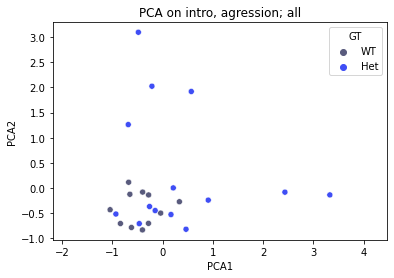

In [21]:
# set parameters for this analysis (stranger directed behaviors for males)
useBehaviors = ['Sniff','Investigate','Huddle','Tussle','Strike','Defensive strike','Mount','Intromission',
                  'Aggression receipt']
useAssays = ['introduction','aggression']
useMetrics = ['count','median']
useSex = 'M'

# do data handling and run PCA
(M_stranger_PCA_DF,M_stranger_PCA) = run_PCA_on_trimmed_data(filled,useAssays,useBehaviors,useMetrics,useSex)

# set up colors depending on target sex
if useSex=='M':
    usepal = mpal
else:
    usepal = fpal

# plotting
tp = sns.scatterplot(data=M_stranger_PCA_DF , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, agression; all')

explained variance ratio (first two components): [0.39113243 0.2651185 ]


Text(0.5, 1.0, 'PCA on intro, reunion; all')

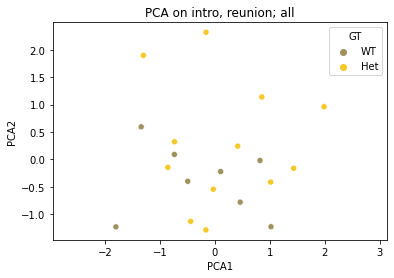

In [22]:
# set parameters for this analysis (partner directed behaviors for females)
useBehaviors = ['Sniff','Investigate','Huddle','Tussle','Strike','Defensive strike','Mount','Intromission',
                  'Aggression receipt']
useAssays = ['introduction','reunion']
useMetrics = ['count','median']
useSex = 'F'

# do data handling and run PCA
(F_partner_PCA_DF,F_partner_PCA) = run_PCA_on_trimmed_data(filled,useAssays,useBehaviors,useMetrics,useSex)

# set up colors depending on target sex
if useSex=='M':
    usepal = mpal
else:
    usepal = fpal

# plotting
tp = sns.scatterplot(data=F_partner_PCA_DF , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, reunion; all')

explained variance ratio (first two components): [0.37154266 0.26806395]


Text(0.5, 1.0, 'PCA on intro, timed mating, reunion, aggression; prosocial; counts only')

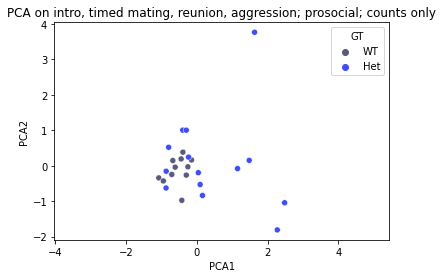

In [24]:
useBehaviors = ['Sniff','Investigate','Huddle']
useAssays = ['introduction','timedMating','reunion','aggression']
useMetrics = ['count']
useSex = 'M'

# do data handling and run PCA
(M_prosoc_PCA_DF,M_prosoc_PCA) = run_PCA_on_trimmed_data(filled,useAssays,useBehaviors,useMetrics,useSex)

# set up colors depending on target sex
if useSex=='M':
    usepal = mpal
else:
    usepal = fpal

# plotting
tp = sns.scatterplot(data=M_prosoc_PCA_DF , x='PCA1', y='PCA2',hue='GT',hue_order=['WT','Het'],palette=usepal)
tp.axis('equal')
tp.set_title('PCA on intro, timed mating, reunion, aggression; prosocial; counts only')